In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from global_import import *
from valuation.val import perform_valuation
from fm import fama_macbeth_reg_panel_nw

In [2]:
LOOKUP_FOLDER = '~/Documents/GitHub/misp/lookup_tables'

def clean_ccm(ccm):
    ccm['permno'] = ccm['permno'].astype(int).astype(str)
    ccm['gvkey'] = ccm['gvkey'].astype(str)
    ccm['linkdt'] = pd.to_datetime(ccm['linkdt'])
    ccm['linkenddt'] = pd.to_datetime(ccm['linkenddt'])
    isnull = ccm['linkenddt'].isnull()
    ccm.loc[isnull, 'linkenddt'] = pd.Timestamp(year=2047, month=7, day=1)
    return ccm

ccm = pd.read_pickle(os.path.join(LOOKUP_FOLDER, 'ccm.pkl'))
ccm_raw = pd.read_pickle(os.path.join(LOOKUP_FOLDER, 'ccm_raw.pkl'))
ccm, ccm_raw = clean_ccm(ccm), clean_ccm(ccm_raw)

In [3]:
syy_a = pd.read_csv(f'{DATA_FOLDER}/syy/annualfactor.csv', index_col=0)
syy_m = pd.read_csv(f'{DATA_FOLDER}/syy/monthlyfactor.csv', index_col=0)
syy_q = pd.read_csv(f'{DATA_FOLDER}/syy/quarterlyfactor.csv', index_col=0)

ccm['gvkey'] = ccm['gvkey'].astype(int)
syy_q = syy_q.merge(ccm, on=['gvkey'])
syy_q = syy_q[['permno', 'year', 'month', 'retonat11']]
syy_a['year']=syy_a.index
syy_a = syy_a.merge(ccm, on=['gvkey'])
syy_a = syy_a[['permno', 'year', 'month', 'netstkis1' ,'accruals3', 'netopat4','atgr5','invtoat6','o8','grpf10']]
syy_q['date'] = pd.to_datetime(syy_q[['year', 'month']].assign(DAY=1))
syy_a['date'] = pd.to_datetime(syy_a[['year', 'month']].assign(DAY=1))
syy_a = syy_a.sort_values(['date'], ascending=True).set_index('date')
syy_q = syy_q.sort_values(['date'], ascending=True).set_index('date')
syy_a = syy_a.drop(columns=['year', 'month'])
syy_q = syy_q.drop(columns=['year', 'month'])
syy_m['date'] = pd.to_datetime(syy_m[['year', 'month']].assign(DAY=1))
syy_m = syy_m.drop(columns=['year', 'month'])
syy_m['permno'] = syy_m.index.astype(int)
syy_m = syy_m.sort_values(['date'], ascending=True).set_index('date')

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
syy_aq = pd.merge_asof(syy_q, syy_a, on='date', direction='backward', by='permno')
syy_aq['permno'] = syy_aq['permno'].astype(int)
syy_aqm = pd.merge_asof(syy_m, syy_aq, left_index=True, right_on='date', direction='backward', by='permno')

In [5]:
syy = syy_aqm.dropna(thresh=10) 
syy['date']=syy['date']+MonthEnd(0)

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
ret_decomp_dcf5 = pd.read_csv(f'{DATA_FOLDER}/decomp_dcf5y_RF_rolling_1980_2019.csv', index_col=0)
ret_decomp_dcf5 = ret_decomp_dcf5[ret_decomp_dcf5.year<=2014]
ret_decomp_dcf5['jdate'] = pd.to_datetime(ret_decomp_dcf5.jdate)
ret_decomp_dcf5 = ret_decomp_dcf5[ret_decomp_dcf5.prc>5]

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [14]:
mdf5 = syy.merge(ret_decomp_dcf5, left_on=['date', 'permno'], right_on=['jdate', 'permno'], how='right')

In [15]:
mdf5 = mdf5.drop_duplicates(subset=['jdate', 'permno'])

<AxesSubplot:>

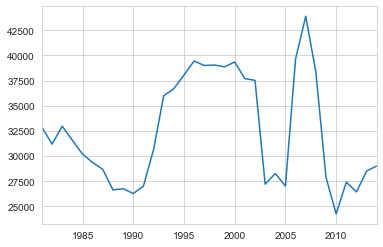

In [16]:
mdf5['year'].value_counts().sort_index().plot()

In [17]:
mdf5 = mdf5.sort_values(['permno', 'date'], ascending=True).set_index('date')

In [18]:
for var in ['compeqis2', 'mmt9','retonat11', 'netstkis1', 'accruals3',
              'netopat4', 'atgr5', 'invtoat6', 'o8', 'grpf10']:
    regdf = mdf5[['jdate', 'permno', 'ticker', var, 'misp']].replace([np.inf, -np.inf], np.nan).dropna()
    print(f'Misp ~ {var}, 5Yr-DCF')
    print(fama_macbeth_reg_panel_nw(regdf, xname=var, yname='misp'))
    print('')

Misp ~ compeqis2, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  408.0  0.174962   0.022643   7.726969      0.053951   3.242998
compeqis2  408.0  0.794328   0.020926  37.958591      0.042253  18.799242

Misp ~ mmt9, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  408.0 -0.218100   0.024026  -9.077705      0.056061  -3.890406
mmt9       408.0  0.056626   0.002452  23.096185      0.005434  10.420184

Misp ~ retonat11, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw  tstat_nw
alpha_i_t  408.0  0.060255   0.021075   2.859019      0.050094  1.202848
retonat11  408.0  2.428032   0.187156  12.973289      0.433507  5.600912

Misp ~ netstkis1, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  408.0 -0.148960   0.023130  -6.440008      0.055225  -2.697334
netstkis1  408.0  0.045055   0.001106  40.748954      0.002600  17.326919

Misp ~ accru

In [19]:
misp_scroe = pd.read_csv(f'{DATA_FOLDER}/Misp_Score.csv', index_col=0)
misp_scroe['date'] = pd.to_datetime(misp_scroe['yyyymm'], format='%Y%m') + MonthEnd(0)
misp_scroe['year'] = misp_scroe['date'].dt.year

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<AxesSubplot:>

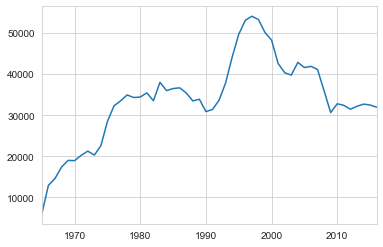

In [20]:
misp_scroe['year'].value_counts().sort_index().plot()

In [21]:
mdf5_with_score = mdf5.merge(misp_scroe, left_on=['jdate', 'permno'], right_on=['date', 'permno'], how='inner')
mdf5_with_score['ret'] = mdf5_with_score['r_t+60']
mdf5_with_score['ret_ct'] = mdf5_with_score['r*_t+60']-1
mdf5_with_score['ret_chg'] = mdf5_with_score['r_chg+60']
mdf5_with_score['avg_score'] = mdf5_with_score['avg_score']/mdf5_with_score['avg_score'].mean()

In [22]:
for m in [3, 6, 12, 24, 36, 48, 60]:
    mdf5_with_score['ret'] = mdf5_with_score[f'r_t+{m}'] # convert log ret to cum ret
    regdf = mdf5_with_score[['jdate', 'permno', 'ticker', 'ret', 'avg_score']].replace([np.inf, -np.inf], np.nan).dropna()
    print(f'{m}-Month Return, 5Yr-DCF')
    print(fama_macbeth_reg_panel_nw(regdf, xname='avg_score'))
    print('')

3-Month Return, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  408.0  0.056398   0.003554  15.868035      0.005578  10.110362
avg_score  408.0 -0.047512   0.003192 -14.885246      0.005545  -8.568370

6-Month Return, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  408.0  0.107153   0.004772  22.455581      0.009332  11.482597
avg_score  408.0 -0.090224   0.004920 -18.336406      0.010267  -8.787862

12-Month Return, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  408.0  0.195311   0.006480  30.142652      0.014053  13.898628
avg_score  408.0 -0.164310   0.007547 -21.771880      0.016988  -9.672130

24-Month Return, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  408.0  0.363655   0.008320  43.709560      0.018887  19.254360
avg_score  408.0 -0.305069   0.009822 -31.059423      0.022602 -13.497731

36-Month R

In [23]:
mdf5_with_score['ret'] = mdf5_with_score['r_t+60']
for var in ['misp', 'ret', 'ret_ct', 'ret_chg']:
    regdf = mdf5_with_score[['jdate', 'permno', 'ticker', var, 'avg_score']].replace([np.inf, -np.inf], np.nan).dropna()
    print(f'{var} ~ Misp Score, 5Yr-DCF')
    print(fama_macbeth_reg_panel_nw(regdf, xname='avg_score', yname=var))
    print('')

misp ~ Misp Score, 5Yr-DCF
           count      mean  std_error     tstat  std_error_nw  tstat_nw
alpha_i_t  408.0  0.094626   0.029246  3.235519      0.069487  1.361768
avg_score  408.0 -0.147947   0.018618 -7.946528      0.043969 -3.364807

ret ~ Misp Score, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  408.0  0.723335   0.013866  52.164601      0.032500  22.256374
avg_score  408.0 -0.607238   0.014255 -42.597154      0.033492 -18.130916

ret_ct ~ Misp Score, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw  tstat_nw
alpha_i_t  408.0 -0.409408   0.036429 -11.238400      0.086289 -4.744636
avg_score  408.0 -0.018150   0.013578  -1.336717      0.031861 -0.569655

ret_chg ~ Misp Score, 5Yr-DCF
           count      mean  std_error     tstat  std_error_nw  tstat_nw
alpha_i_t  408.0 -0.290401   0.040415 -7.185481      0.096004 -3.024894
avg_score  408.0  0.007714   0.017381  0.443804      0.040924  0.188487



In [25]:
mdf5_with_score['ret'] = mdf5_with_score['r_t+36']
for var in ['ret', 'avg_score']:
    regdf = mdf5_with_score[['jdate', 'permno', 'ticker', var, 'misp']].replace([np.inf, -np.inf], np.nan).dropna()
    print(f'{var} ~ Misp, 5Yr-DCF')
    print(fama_macbeth_reg_panel_nw(regdf, xname='misp', yname=var))
    print('')

ret ~ Misp, 5Yr-DCF
           count      mean  std_error     tstat  std_error_nw  tstat_nw
alpha_i_t  408.0  0.076234   0.013056  5.838810      0.030595  2.491729
misp       408.0 -0.016966   0.003577 -4.743037      0.008424 -2.013947

avg_score ~ Misp, 5Yr-DCF
           count      mean  std_error        tstat  std_error_nw    tstat_nw
alpha_i_t  408.0  1.001783   0.000782  1280.900530      0.001818  551.170206
misp       408.0 -0.008354   0.000949    -8.805985      0.002232   -3.743693

